# Exploring Gender Biases in Word2vec 

This notebook defines genism's model and trains it with the Gutenburg and Wikipedia datasets. We also explore different embedding metrics to define a base comparision before we implement debiasing techniques. 


In [1]:
#library imports
import string
import numpy as np
from numpy.linalg import norm
import json
import tempfile
from sklearn.decomposition import PCA
import torch
from torchtext.data.utils import get_tokenizer

#gutenberg data import
from gutenberg_data import get_urls, read_data_from_urls

#models import
from gensim.models import Word2Vec
from custom_word2vec import Custom_Word2Vec

#plots
import matplotlib as plt
import matplotlib.pyplot

Using cuda device


## 1 - Data Preprocessing

In [2]:
def create_tokens(data):
    """
    creates tokenized list with puncuation and digits removed and lowercase words 

    :param data: list of strings
    :return: a list of tokens 
    """ 
    tokens = []
    for sentance in data:
        sentance = sentance.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
        sentance = sentance.translate(str.maketrans('', '', string.digits)) #remove digits
        tokenizer = get_tokenizer("basic_english", language="en") #remove unessasary characters, splits into spaces
        tokens.append(tokenizer(sentance))
  
    return tokens
  

**Gutenburg Dataset**

In [3]:
# Gutenburg
train_urls = get_urls('test')
train_data_g = read_data_from_urls(train_urls)
train_data_g=str(train_data_g[0]).split('.')

sentences_gutenburg = create_tokens(train_data_g)
print("sentances: ",sentences_gutenburg)

sentances:  [['bst'], ['paulrnrnrnetext', 'prepared', 'by', 'josephine', 'paolucci', 'and', 'the', 'project', 'gutenberg', 'onlinerndistributed', 'proofreading', 'teamrnrnrnrnreminiscences', 'of', 'pioneer', 'days', 'in', 'st'], ['paulrnrna', 'collection', 'of', 'articles', 'written', 'for', 'and', 'published', 'in', 'the', 'dailyrnpioneer', 'press'], ['rnrnby', 'frank', 'moorernrnrnrnrnrnrnnewspaper', 'struggles', 'of', 'pioneer', 'days'], ['rnrna', 'brief', 'narration', 'of', 'incidents', 'and', 'events', 'connected', 'with', 'the', 'earlyrndays', 'of', 'st'], ['paul', 'daily', 'newspapers'], ['rnrnrnif', 'james', 'm'], ['goodhue', 'could', 'revisit', 'the', 'earth', 'and', 'make', 'a', 'tour', 'among', 'therndaily', 'newspaper', 'offices', 'of', 'st'], ['paul', 'he', 'would', 'discover', 'that', 'wonderfulrnstrides', 'had', 'been', 'made', 'in', 'the', 'method', 'of', 'producing', 'a', 'newspaper', 'duringrnthe', 'latter', 'half', 'of', 'the', 'past', 'century'], ['among', 'the', 'f

**Wikipedia Dataset**

In [ ]:
#Wikipedia
f = open('wikipedia-en-1000.json')
train_data_w = json.load(f)
train_data_w =str(train_data_w[0]).split('.')

sentences_wikipedia = create_tokens(train_data_w)
print(len(sentences_wikipedia))

159


## 2 - Define Word2Vec - Genism

**Define word 2 vec model** <br>

Using: Skip-gram training algorithm. 

Hyperparameters:
- min_freq: choosing the top N most frequent words - for easier training 
- size: embedding size. We use 300 as per Bolukbasi et al.
- window: the window used for looking at context and center words when traing the embeddings 

In [9]:
min_freq = 1
size = 300
window = 10

#gutenburg model 
model_g = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
model_g.init_weights()
model_g.build_vocab(sentences_gutenburg) 


#wikipedia model
model_w = Word2Vec(min_count=min_freq, vector_size=size, window=window, sg=1) #sg=1 is the skip-gram training algorithm
model_w.init_weights()
model_w.build_vocab(sentences_wikipedia) 



TypeError: ignored

In [10]:
#Useful helper functions for model

def check_w_embedding(word_lists, model, printRemoved):
    '''
    checks if the embedding exists for the given word, and if not deletes it from the lists. 
    if printRemoved = true, it also declares the words that were not in the model embeddings. 
    '''
    new_w_lists = []
    
    for word_list in word_lists:
        new_w_l = []
        for w in word_list: 
            if w in model.wv.key_to_index:
                new_w_l.append(w)
            else:
                if printRemoved:
                    print ("Word", w, " is not in the model")
                    
        new_w_lists.append(new_w_l)
    
    return new_w_lists
    

def w_vec(word, model):
    '''
    returns the word embedding of the input word
    '''
    return model.wv[word]
   

def cos_sim(a,b):
    '''
    returns the cosine similarity between 2 word embeddings 
    '''
    return np.dot(a, b)/(norm(a)*norm(b))

Now, save the embeddings to use in debiasing. 

In [ ]:
with open('gutenburg_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_g.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_g.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")

In [ ]:
with open('wikipedia_embeddings.txt', 'w') as f:
    for idx, key in enumerate(list(model_w.wv.index_to_key)):
        embedding = ' '.join(str(v) for v in model_w.wv.get_vector(key))
        f.write(key + " " + embedding+"\n")

## 3 - Define/Train Word2Vec - Custom

Epoch: 1  Training Loss: 195851.66274499893
Epoch: 2  Training Loss: 182468.41042912006


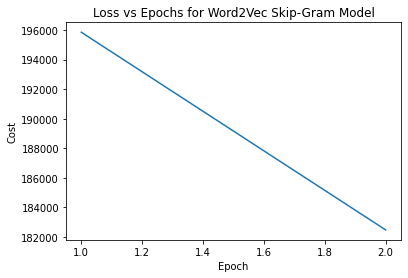

embedding tensor:  [-0.3363074  -0.13186944  0.0372638   0.40506372 -0.14494841  0.06435121
 -0.47271997 -0.03576192  0.55485827  0.38246658]


In [5]:
# gutenburg
embedding_dim=10
LR=0.01
window_size=2
EPOCHS=2

word_2_vec_gutenburg = Custom_Word2Vec(sentences_gutenburg, embedding_dim, LR, window_size, EPOCHS)
word_2_vec_gutenburg.train()

# check first embedding
embedding_1 = word_2_vec_gutenburg.model.embeddings_target(torch.Tensor([1]).long())
print ("embedding tensor: ", embedding_1.detach().cpu().numpy()[0])

## 4 - Measuring Bias

### 4.1 - Construct the g subspace

First, define gendered words and pairs ground truth (taken from Bolukbasi et al.) Using PCA, define the gendered subspace g, by taking the most prominent dimension. 

PCA variance ratio: [3.7489527e-01 2.3151179e-01 2.0511854e-01 1.8847439e-01 8.2512580e-15
 2.9779241e-16]
PCA singular values: [6.2063221e-02 4.8771475e-02 4.5907304e-02 4.4005353e-02 9.2074508e-09
 1.7491866e-09]


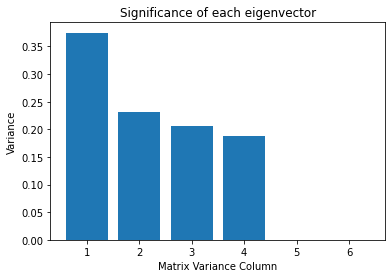

In [ ]:
def gender_subspace_matrix(model, gender_pairs):
    '''
    create matrix of the gender space using gender pairs
        
    '''
    word_directions = []
    for word_pair in gender_pairs:
        f_word = w_vec(word_pair[0],model)
        m_word = w_vec(word_pair[1],model)
        dif = f_word-m_word
        word_directions.append(dif)

    return np.array(word_directions)


def define_vector_g(model, gender_pairs):
    word_directions = gender_subspace_matrix(model, gender_pairs) 

    #PCA of word direction
    pca = PCA(n_components=len(gender_pairs))
    pca.fit(word_directions)

    #print graph of PCA dimensions to determine how many dimensions should be kept
    print("PCA variance ratio:", pca.explained_variance_ratio_)
    print("PCA singular values:", pca.singular_values_)

    #plot graph of eigenvalue variance (basically how relevant each dimension was)
    len_var = len(pca.explained_variance_ratio_)
    plt.pyplot.bar(range(1,len_var+1),pca.explained_variance_ratio_)
    plt.pyplot.xlabel("Matrix Variance Column")
    plt.pyplot.ylabel("Variance")
    plt.pyplot.title("Significance of each eigenvector")

    #use the 1 most prominent dimension
    pca = PCA(n_components=1)
    pca.fit(word_directions)
    g = pca.components_
    
    return g

#gender pairs
#gender_pairs = [['she','he'],['her','his'],['woman','man'],['Mary','John'],['herself','himself'],['daughter','son'],['mother','father'],['gal','guy'],['girl','boy'],['female','male']]
gender_pairs = [['she','he'],['her','his'],['mother','father'],['daughter','son'], ['mother','father'],['female','male']]
gender_pairs = check_w_embedding(gender_pairs, model_g, True)


#define g subspace for each dataset
g_gutenburg = define_vector_g(model_g, gender_pairs)
#g_wikipedia = define_vector_g(model_w,gender_pairs)

### 4.2 - Direct Bias

To measure direct bias, we will be using the equation from Bolukbasi et al. shown below. 

<img src="img/Direct_Bias.png" style="width:300px;float:left;"/>

We will use the same gender neutral words that have been collected from the paper which is 
denoted by N. As well, we will utilize the paper’s gender directions (vector from one word to another) 
which were verified by crowdsourcing. The gender subspace g will be the unit vector g that captures the
gender directions, computed by principal components in the paper. Finally, we will consider c, which is the 
strictness of bias, as a hyperparameter in our experiment. 

In [ ]:
def calculate_direct_metric(gendered_word_set, model, c, g):
    '''
    calculate the direct bias using Bolukbasi et al.'s equation
    '''
    cosine_add = 0
    for word in gendered_word_set:
        cosine_add += np.abs(cos_sim(w_vec(word,model),g[0]))**c
    
    return cosine_add/len(gendered_word_set)
    

c = 1 #hyperparameter
#gendered_words = 'he, his, her, she, him, man, women, men, woman, spokesman, wife, himself, son'
gendered_words = 'he, his, her, she, him, man, women, men, woman, spokesman, wife, himself, son, mother, father, chairman, daughter, husband, guy, girls, girl, boy, boys, brother, spokeswoman, female, sister, male, herself, brothers, dad, actress, mom, sons, girlfriend, daughters, lady, boyfriend, sisters, mothers, king, businessman, grandmother, grandfather, deer, ladies, uncle, males, congressman, grandson, bull, queen, businessmen, wives, widow, nephew, bride, females, aunt, prostate cancer, lesbian, chairwoman, fathers, moms, maiden, granddaughter, younger brother, lads, lion, gentleman, fraternity, bachelor, niece, bulls, husbands, prince, colt, salesman, hers, dude, beard, filly, princess, lesbians, councilman, actresses, gentlemen, stepfather, monks, ex girlfriend, lad, sperm, testosterone, nephews, maid, daddy, mare, fiance, fiancee, kings, dads, waitress, maternal, heroine, nieces, girlfriends, sir, stud, mistress, lions, estranged wife, womb, grandma, maternity, estrogen, ex boyfriend, widows, gelding, diva, teenage girls, nuns, czar, ovarian cancer, countrymen, teenage girl, penis, bloke, nun, brides, housewife, spokesmen, suitors, menopause, monastery, motherhood, brethren, stepmother, prostate, hostess, twin brother, schoolboy, brotherhood, fillies, stepson, congresswoman, uncles, witch, monk, viagra, paternity, suitor, sorority, macho, businesswoman, eldest son, gal, statesman, schoolgirl, fathered, goddess, hubby, stepdaughter, blokes, dudes, strongman, uterus, grandsons, studs, mama, godfather, hens, hen, mommy, estranged husband, elder brother, boyhood, baritone, grandmothers, grandpa, boyfriends, feminism, countryman, stallion, heiress, queens, witches, aunts, semen, fella, granddaughters, chap, widower, salesmen, convent, vagina, beau, beards, handyman, twin sister, maids, gals, housewives, horsemen, obstetrics, fatherhood, councilwoman, princes, matriarch, colts, ma, fraternities, pa, fellas, councilmen, dowry, barbershop, fraternal, ballerina'
gendered_words = gendered_words.split(", ")

#gendered_word_set_w = set(check_w_embedding([gendered_words],model_w,False)[0])
#gendered_word_set_g = set(check_w_embedding([gendered_words],model_g,False)[0])
#gendered_word_set = list(gendered_word_set_w.intersection(gendered_word_set_g))

gendered_word_set = check_w_embedding([gendered_words],model_g,False)[0]
print("gendered word set after filtering: ", gendered_word_set)

direct_gutenburg = calculate_direct_metric(gendered_word_set, model_g, c, g_gutenburg)
#direct_wikipedia = calculate_direct_metric(gendered_word_set, model_w, c, g_wikipedia)

print("Direct metric gutenburg:", direct_gutenburg)


gendered word set after filtering:  ['he', 'his', 'her', 'she', 'him', 'man', 'women', 'men', 'wife', 'himself', 'son', 'mother', 'father', 'daughter', 'husband', 'girls', 'boy', 'boys', 'brother', 'female', 'sister', 'male', 'brothers', 'actress', 'sons', 'lady', 'king', 'ladies', 'uncle', 'bull', 'queen', 'wives', 'fathers', 'maiden', 'gentleman', 'fraternity', 'prince', 'gentlemen', 'lad', 'kings', 'maternal', 'womb', 'countrymen', 'brethren', 'brotherhood', 'statesman', 'goddess', 'baritone', 'queens', 'beau', 'pa']
Direct metric gutenburg: 0.09315754678134587


### 4.3 - Indirect Bias

To measure indirect bias, we will be using the equation from Bolukbasi et al. shown below.

<img src="img/Indirect_Bias.png" style="width:300px;float:left;"/>

$w_{\perp}$ is defined as $w_{\perp} = w - w_{g}$ where $w_{g}=(w*g)*g$ as mentioned in the paper. We will be using the g subspace calculated above. As for the word pairs, we will run a few experiments. The first will be the most extreme words in the softball-football direction as mentioned in the paper. 

In [ ]:
def calculate_indirect_metric(g, w, v):
    wg = np.dot(np.dot(w,g[0]),g[0])
    vg = np.dot(np.dot(v,g[0]),g[0])
    w_norm_vec = w-wg
    v_norm_vec = v-vg
    w_norm = norm(w_norm_vec)
    v_norm = norm(v_norm_vec)
    
    return (np.dot(w,v) - np.dot(w_norm_vec,v_norm_vec)/(w_norm*v_norm))/np.dot(w,v)

def compare_indirect_metrics(words, c_word, model,g):
    metrics=""
    for w in words:
        metrics+=str(calculate_indirect_metric(g, w_vec(c_word,model), w_vec(w,model)))+", "
    
    return metrics


#Future Experiment - Bolukbasi et al. 
#extreme_words_w = ['pitcher','bookkeeper', 'receptionist', 'nurse', 'waitress']
#compare_word_w = 'softball'
#extreme_words_m = ['footballer','businessman', 'pundit', 'maestro', 'cleric']
#compare_word_m = 'football'

#Experiment 1
extreme_words_w = ['family', 'sister', 'marriage', 'charm', 'relatives']
compare_word_w = 'clean'
extreme_words_m = ['paper', 'money', 'office', 'business', 'meeting']
compare_word_m = 'manager'

extreme_words_w,[compare_word_w] = check_w_embedding([extreme_words_w,[compare_word_w]], model_g, True)
metrics_w = compare_indirect_metrics(extreme_words_w, compare_word_w, model_g,g_gutenburg)
print("indirect β values for word 'clean':", metrics_w)

extreme_words_m,[compare_word_w] = check_w_embedding([extreme_words_m,[compare_word_m]], model_g, True)
metrics_m = compare_indirect_metrics(extreme_words_m, compare_word_m, model_g,g_gutenburg)
print("indirect β values for word 'manager':", metrics_m)
    

indirect β values for word 'clean': -938.91296, -926.94385, -775.27264, -869.30945, -910.7613, 
indirect β values for word 'manager': -898.9482, -933.16833, -884.65454, -905.6266, -903.878, 


### 4.4 - WEAT Metric

To measure WEAT, we used the formula defined in Caliskan et al., which is an additional direct bias measure. 

<img src="img/WEAT.png" style="width:300px;float:left;"/>

In [ ]:
def s_word_A_B(w,A,B,model):
    mean_A_sum = 0
    mean_B_sum = 0
    w_v = w_vec(w,model)
    
    for a in A:
        a_vec = w_vec(a,model)
        mean_A_sum +=cos_sim(w_v,a_vec)
    
    for b in B:
        b_vec = w_vec(b,model)
        mean_B_sum +=cos_sim(w_v,b_vec)
        
    return mean_A_sum/len(A) - mean_B_sum/len(B)

def s_X_Y_A_B(X,Y,A,B,model):
    sum_X = 0
    sum_Y = 0
    
    for x in X:
        sum_X += s_word_A_B(x,A,B,model)
        
    for y in Y:
        sum_Y += s_word_A_B(y,A,B,model)
    
    return sum_X - sum_Y

Now, lets run experiments on the models <br>
A and B are the attribute word groups (8 words each), and X,Y are the target words

In [ ]:
#Experiment 1 - work/family
A = ['tie', 'manager', 'work', 'paper', 'money', 'office', 'business', 'meeting']
B = ['home', 'parents', 'children', 'family', 'sister', 'marriage', 'charm', 'relatives']
X = ['he', 'him']
Y = ['she', 'her'] 

A,B,X,Y = check_w_embedding([A,B,X,Y], model_g, True)
metric_exp_1_g = s_X_Y_A_B(X,Y,A,B,model_g)

#A,B,X,Y = check_w_embedding([A,B,X,Y], model_w, True)
#metric_exp_1_w = s_X_Y_A_B(X,Y,A,B,model_w)

print ("WEAT Exp 1:", metric_exp_1_g)

#Experiment 2 - professions
A_2 = ['police', 'manager', 'business', 'lawyers', 'engineer', 'program', 'builder', 'fire']
B_2 = ['teachers', 'clean', 'social', 'hair', 'nail', 'make', 'writer', 'library'] 

A_3,B_3,X,Y = check_w_embedding([A_2,B_2,X,Y], model_g, True)
metric_exp_2_g = s_X_Y_A_B(X,Y,A_2,B_2,model_g)

#A_3,B_3,X,Y = check_w_embedding([A_3,B_3,X,Y], model_w, True)
#metric_exp_2_w = s_X_Y_A_B(X,Y,A_3,B_3,model_w)

print ("WEAT Exp 2:", metric_exp_3_g)



WEAT Exp 1: -0.006268933910178021
WEAT Exp 2: -0.0604922525017173
